[![gammapy](https://img.shields.io/badge/powered%20by-gammapy-orange.svg?style=flat)](https://gammapy.org/)


# Gammapy Part II: Spectral Model Fit
**Tutors:** M Felipe Sousa and Rubens Costa Jr.

This hands-on tutorial aims to illustrate model management in Gammapy, specially how to distribute multiple models across multiple datasets. We also show some convenience functions built in gammapy for handling multiple model components and fit spectral models to combined Fermi-LAT and IACT flux points tables of the Crab Nebula.


## Preface
We recommend to follow this tutorial by **executing the code cells on your local machine**, along with the tutor.

We're happy to receive any **feedback or questions** on the tutorial via mail to *manoelfelipesousa@gmail.com* or *rubensjrcosta@gmail.com*.


<a id='intro'></a>
## Indice
* [**1. Modelling**](#Modelling)
   * Adding spectral models for each dataset
   * Sharing a model between multiple datasets
   * Adding and removing models
   * freezing and thawing multiple model parameters together

* [**2. Flux point fitting**](#fpfitting)
   * Fitting the spectral points with various spectral models
   * Estimating the signifiance of the source.





## Setup

In [ ]:
# !pip install gammapy

In [1]:
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.time import Time
from regions import CircleSkyRegion
from scipy.stats import chi2, norm
import matplotlib.pyplot as plt
import numpy as np

# %matplotlib inline
from IPython.display import display
from gammapy.datasets import Datasets, MapDataset
from gammapy.modeling import Fit
from gammapy.maps import Map
from gammapy.stats.utils import ts_to_sigma
from gammapy.modeling.models import (
    Models,
    ExpCutoffPowerLawSpectralModel,
    PowerLawSpectralModel,
    PowerLawNormSpectralModel,
    LogParabolaSpectralModel,
    SkyModel,
)



## Check setup



In [2]:
from gammapy.utils.check import check_tutorials_setup

check_tutorials_setup()


System:

	python_executable      : /home/felipe/miniconda3/envs/gammapy-1.1/bin/python 
	python_version         : 3.9.18     
	machine                : x86_64     
	system                 : Linux      


Gammapy package:

	version                : 1.1        
	path                   : /home/felipe/miniconda3/envs/gammapy-1.1/lib/python3.9/site-packages/gammapy 


Other packages:

	numpy                  : 1.24.4     
	scipy                  : 1.10.1     
	astropy                : 5.3.3      
	regions                : 0.7        
	click                  : 8.1.3      
	yaml                   : 6.0.1      
	IPython                : 8.7.0      
	jupyterlab             : 3.5.3      
	matplotlib             : 3.7.2      
	pandas                 : 1.5.2      
	healpy                 : 1.16.5     
	iminuit                : 2.21.3     
	sherpa                 : 4.15.1     
	naima                  : 0.10.0     
	emcee                  : 3.1.3      
	corner                 : 2.2.1      
	ray    

<a id='gammapy'></a>
## 1. Modelling

To show how datasets interact with models, we use two pre-computed datasets from the Crab nebula.


### Read the datasets

First, we read some precomputed datasets


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
DATA_PATH = "/home/felipe/Github/Gammapy_introduction/WorkshopIntroducaoAoGammapy/data"


In [4]:
datasets_all = Datasets.read(f"{DATA_PATH}/gammapy_spectral/datasets-crab.yaml")


No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.
No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.
No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.
No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.


In [8]:
print(datasets_all)

Datasets
--------

Dataset 0: 

  Type       : FluxPointsDataset
  Name       : Crab nebula: gamma-cat
  Instrument : 
  Models     : 

Dataset 1: 

  Type       : FluxPointsDataset
  Name       : 4FGL J0534.5+2200
  Instrument : 
  Models     : 

Dataset 2: 

  Type       : FluxPointsDataset
  Name       : 2FHL J0534.5+2201
  Instrument : 
  Models     : 

Dataset 3: 

  Type       : FluxPointsDataset
  Name       : 3FHL J0534.5+2201
  Instrument : 
  Models     : 




and create a `Datasets` object containing two datasets.


In [9]:
datasets_c2 = Datasets([datasets_all[0], datasets_all[3]])

print(datasets_c2)

Datasets
--------

Dataset 0: 

  Type       : FluxPointsDataset
  Name       : Crab nebula: gamma-cat
  Instrument : 
  Models     : 

Dataset 1: 

  Type       : FluxPointsDataset
  Name       : 3FHL J0534.5+2201
  Instrument : 
  Models     : 




In [ ]:
# print(datasets_c2[0])

The table with the corresponding flux points data can be accessed with `.data.to_table` attribute

In [13]:
datasets_c2[0].data.to_table(sed_type="dnde", formatted=True )

e_ref,dnde,dnde_errp,dnde_errn,is_ul
TeV,1 / (TeV s cm2),1 / (TeV s cm2),1 / (TeV s cm2),
float64,float64,float64,float64,bool
0.519,1.810e-10,6.000e-12,6.000e-12,False
0.729,7.270e-11,2.000e-12,1.900e-12,False
1.060,3.120e-11,9.000e-13,9.000e-13,False
1.550,1.220e-11,4.000e-13,4.000e-13,False
2.260,4.600e-12,1.800e-13,1.800e-13,False
3.300,1.530e-12,8.000e-14,8.000e-14,False
4.890,6.350e-13,3.900e-14,3.800e-14,False
7.180,2.270e-13,1.800e-14,1.700e-14,False


### Assigning spectral models to datasets

To attach a model on a particular dataset it is necessary to specify the
`datasets_names`. Otherwise, by default, the model will be applied to
all the datasets in `datasets`


Examples of spectral models can be found here: https://docs.gammapy.org/1.1/user-guide/model-gallery/index.html


In [14]:
datasets_c2[0].name

'Crab nebula: gamma-cat'

In [15]:
models = Models()  # global models object


# Create the spectral model for the first dataset

model_ecpl = ExpCutoffPowerLawSpectralModel()

crab_ecpl = SkyModel(spectral_model=model_ecpl,
                     name="crab_ecpl",
                     datasets_names=[datasets_c2[0].name],  # specifying the dataset name
                    )

models.append(crab_ecpl)  # Add the ecpl_model to models()


# Create the spectral model for the second dataset

model_pl = PowerLawSpectralModel()

crab_pl = SkyModel(spectral_model=model_pl,
                   name="crab_pl",
                   datasets_names=[datasets_c2[1].name],  # specifying the dataset name
                  )

models.append(crab_pl)  # Add the fpl_model to models()


In [16]:
print(models)

Models

Component 0: SkyModel

  Name                      : crab_ecpl
  Datasets names            : ['Crab nebula: gamma-cat']
  Spectral model type       : ExpCutoffPowerLawSpectralModel
  Spatial  model type       : 
  Temporal model type       : 
  Parameters:
    index                         :      1.500   +/-    0.00             
    amplitude                     :   1.00e-12   +/- 0.0e+00 1 / (TeV s cm2)
    reference             (frozen):      1.000       TeV         
    lambda_                       :      0.100   +/-    0.00 1 / TeV     
    alpha                 (frozen):      1.000                   

Component 1: SkyModel

  Name                      : crab_pl
  Datasets names            : ['3FHL J0534.5+2201']
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : 
  Temporal model type       : 
  Parameters:
    index                         :      2.000   +/-    0.00             
    amplitude                     :   1.00e-12   +/- 0.0e+00 1

In [19]:
# Now, add the models to datasets
datasets_c2.models = models

# You can see that each dataset lists the correct associated models
print(datasets_c2)

Datasets
--------

Dataset 0: 

  Type       : FluxPointsDataset
  Name       : Crab nebula: gamma-cat
  Instrument : 
  Models     : ['crab_ecpl']

Dataset 1: 

  Type       : FluxPointsDataset
  Name       : 3FHL J0534.5+2201
  Instrument : 
  Models     : ['crab_pl']




### Add a model on multiple datasets

In this section, we show how to add a model to multiple datasets. For
this, we specify a list of `datasets_names` to the model.
Alternatively, not specifying any `datasets_names` will add it to all
the datasets.



In [20]:
# Create another spectral model

crab_lp = SkyModel(
    spectral_model=LogParabolaSpectralModel(),
    name="crab_lp",
#    datasets_names=[datasets_c2[0].name, datasets_c2[1].name],
)

# Now, add the Log Parabola model to the global models list
models.append(crab_lp)

# add it to the datasets, and inspect
datasets_c2.models = models
print(datasets_c2)

Datasets
--------

Dataset 0: 

  Type       : FluxPointsDataset
  Name       : Crab nebula: gamma-cat
  Instrument : 
  Models     : ['crab_ecpl', 'crab_lp']

Dataset 1: 

  Type       : FluxPointsDataset
  Name       : 3FHL J0534.5+2201
  Instrument : 
  Models     : ['crab_pl', 'crab_lp']




In [21]:
print(datasets_c2[0])

FluxPointsDataset
-----------------

  Name                            : Crab nebula: gamma-cat 

  Number of total flux points     : 12 
  Number of fit bins              : 12 

  Fit statistic type              : chi2
  Fit statistic value (-2 log(L)) : 52704.13

  Number of models                : 2 
  Number of parameters            : 9
  Number of free parameters       : 6

  Component 0: SkyModel
  
    Name                      : crab_ecpl
    Datasets names            : ['Crab nebula: gamma-cat']
    Spectral model type       : ExpCutoffPowerLawSpectralModel
    Spatial  model type       : 
    Temporal model type       : 
    Parameters:
      index                         :      1.500   +/-    0.00             
      amplitude                     :   1.00e-12   +/- 0.0e+00 1 / (TeV s cm2)
      reference             (frozen):      1.000       TeV         
      lambda_                       :      0.100   +/-    0.00 1 / TeV     
      alpha                 (frozen):      1.0

The `Log Parabola` model is correctly present on both. Now, you can
proceed with the fit. For computational purposes, we skip it in this
notebook



### Loading models from a catalog

We now load the Fermi 3FHL catalog and demonstrate some convenience
functions. For more details on using Gammapy catalog, see the
:doc:`/tutorials/api/catalog` tutorial.




In [ ]:
import os # Miscellaneous operating system interfaces
os.environ['GAMMAPY_DATA'] = os.path.join(os.getcwd(), '/content/gammapy-data/1.2')

In [23]:
from gammapy.catalog import SourceCatalog3FHL

catalog = SourceCatalog3FHL()

In [24]:
print(catalog)

SourceCatalog3FHL:
    name: 3fhl
    description: LAT third high-energy source catalog
    sources: 1556



We first choose some relevant models from the catalog and create a new
`Models` object.




In [27]:
gc_sep

<Angle [ 86.7964  ,  99.68222 , 107.675354, ...,  71.99661 ,  96.06577 ,
         92.2772  ] deg>

In [28]:
Crab_pos = SkyCoord(83.6333, 22.0133, unit="deg", frame="icrs")

gc_sep = catalog.positions.separation(Crab_pos)
models_3fhl = [_.sky_model() for k, _ in enumerate(catalog) if gc_sep[k].value < 8]
models_3fhl = Models(models_3fhl)

print(len(models_3fhl))

8


In [ ]:
# print(len(catalog.positions))

In [29]:
print(models_3fhl)

Models

Component 0: SkyModel

  Name                      : 3FHL J0510.0+1800
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      3.069   +/-    0.31             
    amplitude                     :   7.78e-12   +/- 1.2e-12 1 / (GeV s cm2)
    reference             (frozen):     16.305       GeV         
    lon_0                         :     77.521   +/-    0.01 deg         
    lat_0                         :     18.009   +/-    0.01 deg         

Component 1: SkyModel

  Name                      : 3FHL J0515.8+1528
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      2.321   +/-    0.20             
    amplitude                     :   3.67e-12   +

### Selecting models contributing to a given region

We now use `Models.select_region()` to get a subset of models
contributing to a particular region. You can also use
`Models.select_mask()` to get models lying inside the `True` region
of a mask map\`




In [30]:
region = CircleSkyRegion(
    center=SkyCoord(83.6333, 22.0133, unit="deg", frame="icrs"), radius=3.0 * u.deg
)

models_selected = models_3fhl.select_region(region)
print(len(models_selected))

1


In [31]:
print(models_selected)

Models

Component 0: SkyModel

  Name                      : 3FHL J0534.5+2201
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      2.220   +/-    0.02             
    amplitude                     :   1.71e-10   +/- 3.4e-12 1 / (GeV s cm2)
    reference             (frozen):     22.726       GeV         
    lon_0                         :     83.635   +/-    0.00 deg         
    lat_0                         :     22.019   +/-    0.00 deg         




We now want to assign `models_3fhl` to the first dataset, and
`models_selected` to both datasets. For this, we
explicitly mention the `datasets_names` to the former, and leave it
`None` (default) for the latter.




In [32]:
print(datasets_c2)

Datasets
--------

Dataset 0: 

  Type       : FluxPointsDataset
  Name       : Crab nebula: gamma-cat
  Instrument : 
  Models     : ['crab_ecpl', 'crab_lp']

Dataset 1: 

  Type       : FluxPointsDataset
  Name       : 3FHL J0534.5+2201
  Instrument : 
  Models     : ['crab_pl', 'crab_lp']




In [33]:
for model in models_3fhl:
    if model not in models_selected:
        model.datasets_names = datasets_c2[0].name

# assign the models to datasets
datasets_c2.models = models_3fhl

In [34]:
print(models_3fhl)

Models

Component 0: SkyModel

  Name                      : 3FHL J0510.0+1800
  Datasets names            : Crab nebula: gamma-cat
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      3.069   +/-    0.31             
    amplitude                     :   7.78e-12   +/- 1.2e-12 1 / (GeV s cm2)
    reference             (frozen):     16.305       GeV         
    lon_0                         :     77.521   +/-    0.01 deg         
    lat_0                         :     18.009   +/-    0.01 deg         

Component 1: SkyModel

  Name                      : 3FHL J0515.8+1528
  Datasets names            : Crab nebula: gamma-cat
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      2.321   +/-    0.20             
    amplitude 

To see the models on a particular dataset, you can simply see




In [35]:
print("First dataset models: ", datasets_c2[0].models.names)
print()
print("Second dataset models: ", datasets_c2[1].models.names)

First dataset models:  ['3FHL J0510.0+1800', '3FHL J0515.8+1528', '3FHL J0521.7+2112', '3FHL J0524.5+2838', '3FHL J0534.5+2201', '3FHL J0536.2+1733', '3FHL J0537.6+2751e', '3FHL J0538.7+1643']

Second dataset models:  ['3FHL J0534.5+2201']


In [36]:
print(datasets_c2)

Datasets
--------

Dataset 0: 

  Type       : FluxPointsDataset
  Name       : Crab nebula: gamma-cat
  Instrument : 
  Models     : ['3FHL J0510.0+1800', '3FHL J0515.8+1528', '3FHL J0521.7+2112', '3FHL J0524.5+2838', '3FHL J0534.5+2201', '3FHL J0536.2+1733', '3FHL J0537.6+2751e', '3FHL J0538.7+1643']

Dataset 1: 

  Type       : FluxPointsDataset
  Name       : 3FHL J0534.5+2201
  Instrument : 
  Models     : ['3FHL J0534.5+2201']




### Combining two Models




`Models` can be extended simply as as python lists




In [37]:
print(models)

Models

Component 0: SkyModel

  Name                      : crab_ecpl
  Datasets names            : ['Crab nebula: gamma-cat']
  Spectral model type       : ExpCutoffPowerLawSpectralModel
  Spatial  model type       : 
  Temporal model type       : 
  Parameters:
    index                         :      1.500   +/-    0.00             
    amplitude                     :   1.00e-12   +/- 0.0e+00 1 / (TeV s cm2)
    reference             (frozen):      1.000       TeV         
    lambda_                       :      0.100   +/-    0.00 1 / TeV     
    alpha                 (frozen):      1.000                   

Component 1: SkyModel

  Name                      : crab_pl
  Datasets names            : ['3FHL J0534.5+2201']
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : 
  Temporal model type       : 
  Parameters:
    index                         :      2.000   +/-    0.00             
    amplitude                     :   1.00e-12   +/- 0.0e+00 1

In [38]:
models.extend(models_selected)
print(len(models))

4


### Selecting models from a list

A `Model` can be selected from a list of `Models` by specifying its
index or its name.




In [39]:
model = models_3fhl[0]
print(model)

# Alternatively
model = models_3fhl["3FHL J0510.0+1800"]
print(model)

SkyModel

  Name                      : 3FHL J0510.0+1800
  Datasets names            : Crab nebula: gamma-cat
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      3.069   +/-    0.31             
    amplitude                     :   7.78e-12   +/- 1.2e-12 1 / (GeV s cm2)
    reference             (frozen):     16.305       GeV         
    lon_0                         :     77.521   +/-    0.01 deg         
    lat_0                         :     18.009   +/-    0.01 deg         


SkyModel

  Name                      : 3FHL J0510.0+1800
  Datasets names            : Crab nebula: gamma-cat
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      3.069   +/-    0.31             
    amplitude                     :   7.78e-12 

### Removing a model from a dataset




Any addition or removal of a model must happen through the global models
object, which must then be re-applied on the dataset(s). Note that
operations **cannot** be directly performed on `dataset.models()`.




In [41]:
# datasets_c2.models.remove()
# * this is forbidden *

# Remove the model '3FHL J0510.0+1800'
models_3fhl.remove("3FHL J0510.0+1800")


# After any operation on models, it must be re-applied on the datasets
datasets_c2.models = models_3fhl

To see the models applied on a dataset, you can simply




In [42]:
len(models_3fhl)

7

In [43]:
print(datasets_c2.models.names)

['3FHL J0515.8+1528', '3FHL J0521.7+2112', '3FHL J0524.5+2838', '3FHL J0534.5+2201', '3FHL J0536.2+1733', '3FHL J0537.6+2751e', '3FHL J0538.7+1643']


### Freezing and unfreezing model parameters

For a given model, any parameter can be (un)frozen individually.
Additionally, `model.freeze` and `model.unfreeze` can be used to
freeze and unfreeze all parameters in one go.




In [52]:
model = models_3fhl[0]
print(model)

SkyModel

  Name                      : 3FHL J0515.8+1528
  Datasets names            : Crab nebula: gamma-cat
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      2.321   +/-    0.20             
    amplitude                     :   3.67e-12   +/- 5.7e-13 1 / (GeV s cm2)
    reference             (frozen):     21.884       GeV         
    lon_0                         :     78.955   +/-    0.01 deg         
    lat_0                         :     15.467   +/-    0.01 deg         




SkyModel

  Name                      : 3FHL J0515.8+1528
  Datasets names            : Crab nebula: gamma-cat
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      2.321   +/-    0.20             
    amplitude                     :   3.67e-12   +/- 5.7e-13 1 / (GeV s cm2)
    reference                     :     21.884   +/-    0.00 GeV         
    lon_0                         :     78.955   +/-    0.01 deg         
    lat_0                         :     15.467   +/-    0.01 deg         




In [53]:
model = models_3fhl[0]
print(model)

# To freeze a single parameter
model.spectral_model.index.frozen = True
print(model)  # index is now frozen

# To unfreeze a parameter
model.spectral_model.index.frozen = False

# To freeze all parameters of a model
model.freeze()
print(model)

# To unfreeze all parameters (except parameters which must remain frozen)
model.unfreeze()
print(model)

SkyModel

  Name                      : 3FHL J0515.8+1528
  Datasets names            : Crab nebula: gamma-cat
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      2.321   +/-    0.20             
    amplitude                     :   3.67e-12   +/- 5.7e-13 1 / (GeV s cm2)
    reference             (frozen):     21.884       GeV         
    lon_0                         :     78.955   +/-    0.01 deg         
    lat_0                         :     15.467   +/-    0.01 deg         


SkyModel

  Name                      : 3FHL J0515.8+1528
  Datasets names            : Crab nebula: gamma-cat
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                 (frozen):      2.321                   
    amplitude                     :   3.67e-12   +/- 5.

Only spectral or spatial or temporal components of a model can also be
frozen




In [54]:
# To freeze spatial components
model.freeze("spatial")
print(model)

SkyModel

  Name                      : 3FHL J0515.8+1528
  Datasets names            : Crab nebula: gamma-cat
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      2.321   +/-    0.20             
    amplitude                     :   3.67e-12   +/- 5.7e-13 1 / (GeV s cm2)
    reference             (frozen):     21.884       GeV         
    lon_0                 (frozen):     78.955       deg         
    lat_0                 (frozen):     15.467       deg         




To check if all the parameters of a model are frozen,




In [55]:
print(model.frozen)  # False because spectral components are not frozen

print(model.spatial_model.frozen)  # all spatial components are frozen

False
True


The same operations can be performed on `Models` directly - to perform
on a list of models at once, eg




In [56]:
models_selected.freeze()  # freeze all parameters of all models

models_selected.unfreeze()  # unfreeze all parameters of all models

# print the free parameters in the models
print(models_selected.parameters.free_parameters.names)

['index', 'amplitude', 'lon_0', 'lat_0']


There are more functionalities which you can explore. In general, using
`help()` on any function is a quick and useful way to access the
documentation. For ex, `Models.unfreeze_all` will unfreeze all
parameters, even those which are fixed by default. To see its usage, you
can simply type




In [57]:
help(models_selected.unfreeze)

Help on method unfreeze in module gammapy.modeling.models.core:

unfreeze(model_type=None) method of gammapy.modeling.models.core.Models instance
    Restore parameters frozen status to default depending on model type
    
    Parameters
    ----------
    model_type : {None, "spatial", "spectral"}
       restore frozen status to default for all parameters or only spatial or only spectral



<a id='gammapy'></a>
## 2. Flux point fitting

Here we will load the spectral points of the Crab Nebula and fit them with various spectral models to find the best representation of the wide-band spectrum.




We will use the previously loaded dataset (dataset_all) that contains the four datasets

Let's plot the flow points

In [ ]:
# print(datasets_all)

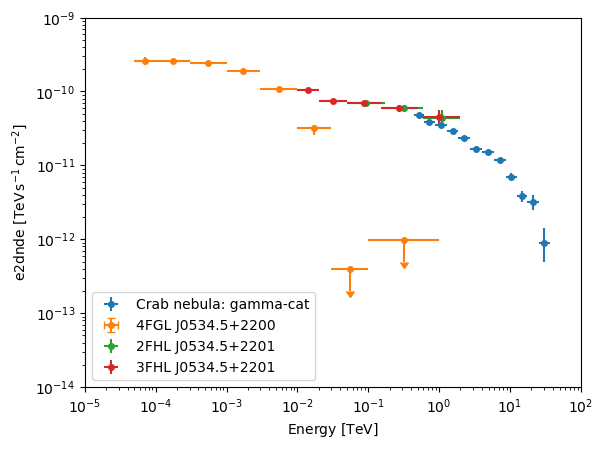

In [58]:
ax = plt.subplot()
ax.yaxis.set_units(u.Unit("TeV cm-2 s-1"))

kwargs = {"ax": ax, "sed_type": "e2dnde"}

for d in datasets_all:
    d.data.plot(label=d.name, **kwargs)

energy_bounds = [1e-5, 1e2] * u.TeV
ax.set_ylim(1e-14, 1e-9)
ax.set_xlim(energy_bounds)
ax.legend()
plt.show()

### Power Law Fit


First we start with fitting a simple `PowerLawSpectralModel`.


In [63]:
pwl = PowerLawSpectralModel(
    index=2, amplitude="1e-12 cm-2 s-1 TeV-1", reference="1 TeV"
)

# pwl.index.max = 3
# pwl.index.min = 2

model_pwl = SkyModel(spectral_model=pwl, name="crab-pl")

In [64]:
model_pwl.parameters.to_table()

type,name,value,unit,error,min,max,frozen,is_norm,link
str8,str9,float64,str14,int64,float64,float64,bool,bool,str1
spectral,index,2.0000e+00,,0.000e+00,nan,nan,False,False,
spectral,amplitude,1.0000e-12,TeV-1 s-1 cm-2,0.000e+00,nan,nan,False,True,
spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,


After creating the model we run the fit by passing the `flux_points` and `model` objects:


In [65]:
datasets_all.models = model_pwl


fitter = Fit()
result_pwl = fitter.run(datasets=datasets_all)
print(result_pwl)

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully..
	nfev       : 156
	total stat : 1764.48

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.



In [66]:
result_pwl.models.to_parameters_table()

model,type,name,value,unit,error,min,max,frozen,is_norm,link
str7,str8,str9,float64,str14,float64,float64,float64,bool,bool,str1
crab-pl,spectral,index,2.2942e+00,,1.569e-03,nan,nan,False,False,
crab-pl,spectral,amplitude,2.6437e-11,TeV-1 s-1 cm-2,2.749e-13,nan,nan,False,True,
crab-pl,spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,


Finally we plot the data points and the best fit model:


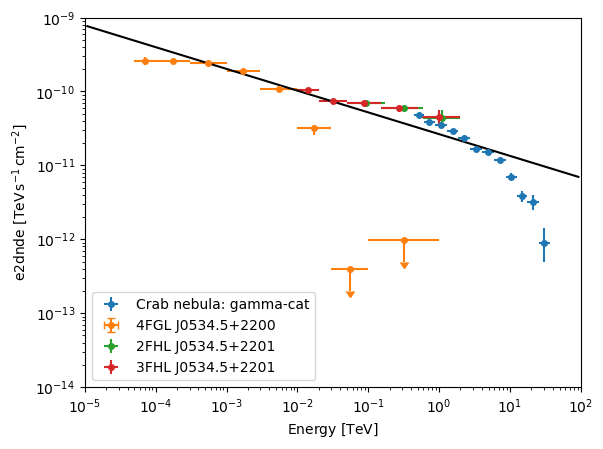

In [67]:
ax = plt.subplot()
ax.yaxis.set_units(u.Unit("TeV cm-2 s-1"))

kwargs = {"ax": ax, "sed_type": "e2dnde"}

for d in datasets_all:
    d.data.plot(label=d.name, **kwargs)

energy_bounds = [1e-5, 1e2] * u.TeV

pwl.plot(energy_bounds=energy_bounds, color="k", **kwargs)
pwl.plot_error(energy_bounds=energy_bounds, **kwargs)

ax.set_ylim(1e-14, 1e-9)
ax.set_xlim(energy_bounds)
ax.legend()
plt.show()


The value of the quantity $-2\ln\mathcal(L)$ for the Power Law model can be simply computed as

In [68]:
Stat_0 = result_pwl.total_stat
print(Stat_0)

1764.482937848233


### Exponential Cut-Off Powerlaw Fit


Next we fit an `ExpCutoffPowerLawSpectralModel` law to the data.


In [71]:
ecpl = ExpCutoffPowerLawSpectralModel(
    index=1.8,
    amplitude="2e-12 cm-2 s-1 TeV-1",
    reference="1 TeV",
    lambda_="0.1 TeV-1",
)

model_ecpl = SkyModel(spectral_model=ecpl, name="crab-ecpl")


We run the fitter again by passing the flux points and the model instance:



In [72]:
print(model_ecpl)

SkyModel

  Name                      : crab-ecpl
  Datasets names            : None
  Spectral model type       : ExpCutoffPowerLawSpectralModel
  Spatial  model type       : 
  Temporal model type       : 
  Parameters:
    index                         :      1.800   +/-    0.00             
    amplitude                     :   2.00e-12   +/- 0.0e+00 1 / (TeV s cm2)
    reference             (frozen):      1.000       TeV         
    lambda_                       :      0.100   +/-    0.00 1 / TeV     
    alpha                 (frozen):      1.000                   




In [73]:
datasets_all.models = model_ecpl
fitter2 = Fit()
result_ecpl = fitter2.run(datasets=datasets_all)

print(result_ecpl)
print(model_ecpl)

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully..
	nfev       : 278
	total stat : 537.52

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.

SkyModel

  Name                      : crab-ecpl
  Datasets names            : None
  Spectral model type       : ExpCutoffPowerLawSpectralModel
  Spatial  model type       : 
  Temporal model type       : 
  Parameters:
    index                         :      2.236   +/-    0.00             
    amplitude                     :   3.94e-11   +/- 6.1e-13 1 / (TeV s cm2)
    reference             (frozen):      1.000       TeV         
    lambda_                       :      0.119   +/-    0.01 1 / TeV     
    alpha                 (frozen):      1.000                   




We plot the data and best fit model:



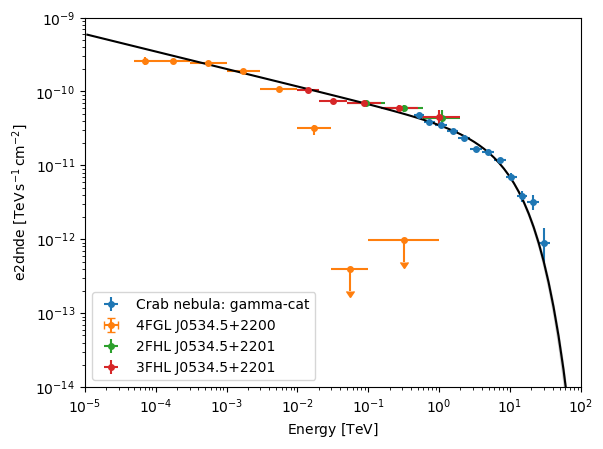

In [78]:
ax = plt.subplot()
ax.yaxis.set_units(u.Unit("TeV cm-2 s-1"))

kwargs = {"ax": ax, "sed_type": "e2dnde"}

for d in datasets_all:
    d.data.plot(label=d.name, **kwargs)

energy_bounds = [1e-5, 1e2] * u.TeV

ecpl.plot(energy_bounds=energy_bounds, color="k", **kwargs)
ecpl.plot_error(energy_bounds=energy_bounds, **kwargs)

ax.set_ylim(1e-14, 1e-9)
ax.set_xlim(energy_bounds)
ax.legend()
plt.show()


The value of the quantity $-2\ln\mathcal(L)$ for the Exponential Cut-Off Powerlaw model can be simply computed as

In [79]:
Stat_1 = result_ecpl.total_stat
print(Stat_1)

537.519170615171


### Test Statistics

**Test hypotheses: Likelihood-ratio test**

* Null hypothesis: the log-likelihoods from one model is equal to the other (H0: log-likelihood model 1 - log-likelihood model 2 = 0)

* Alt hypothesis: the log-likelihoods are not equal to one another (HA: log-likelihood model 1 - log-likelihood model 2 ≠ 0)

Interpretation:

If the p value for the test is < 'X', then we reject the null hypothesis and one model improves the fit of the model.

In [ ]:
# result_pwl.models.parameters.free_parameters.names

In [84]:
# standard formula is TS=-2(LogLike1-LogLike0) but default stat in gammapy is -2 log(L)
delta_ts = Stat_0-Stat_1   # -(Stat_1-Stat_0)

df = len(result_ecpl.models.parameters.free_parameters.names)-len(result_pwl.models.parameters.free_parameters.names)

sigma = ts_to_sigma(delta_ts, df=df)

print(f"The delta_ts  of H1 vs H0: {delta_ts:.3f}, that gives a p-value of {chi2.sf(delta_ts, df)}")
print(f"Converting this to a significance gives: {sigma:.3f} \u03C3")

The delta_ts  of H1 vs H0: 1226.964, that gives a p-value of 8.421203258693439e-269
Converting this to a significance gives: 35.028 σ


In [86]:
print(Stat_0)
print(Stat_1)

1764.482937848233
537.519170615171


To check that the fit has coverged correctly, it is always a good idea to inspect the likelihood profile for the free model parameters.

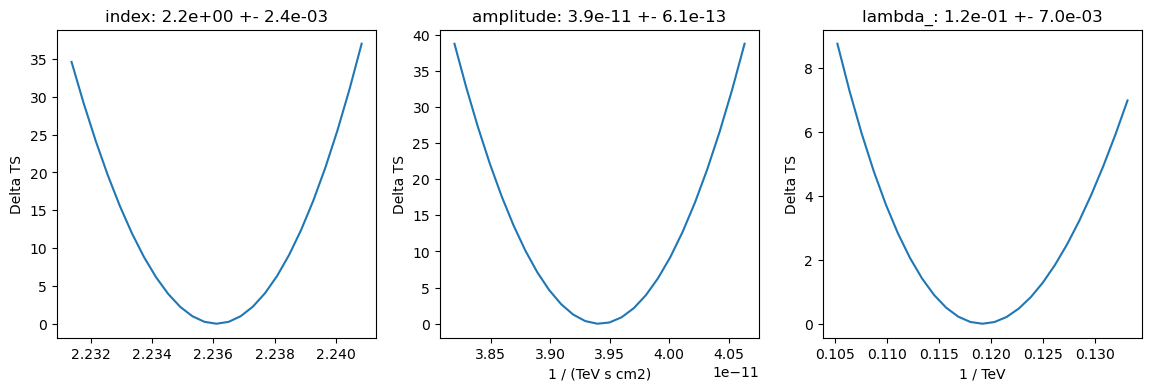

In [87]:
total_stat = result_ecpl.total_stat

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14, 4))

for ax, par in zip(axes, model_ecpl.parameters.free_parameters):
    par.scan_n_values = 25

    profile = fitter2.stat_profile(datasets=datasets_all, parameter=par)
    ax.plot(profile[f"{model_ecpl.name}.spectral.{par.name}_scan"], profile["stat_scan"] - total_stat)
    ax.set_xlabel(f"{par.unit}")
    ax.set_ylabel("Delta TS")
    ax.set_title(f"{par.name}: {par.value:.1e} +- {par.error:.1e}")

### Covariance

After the fit the covariance matrix is attached to the models copy stored on the `FitResult` object and we can plot the total parameter correlation as well.

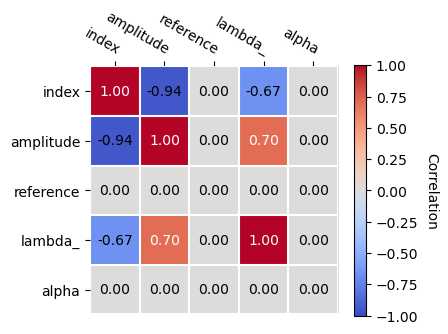

In [88]:
result_ecpl.models.covariance.plot_correlation()
plt.show()

### Confidence contours

A confidence contour is a 2-dimensional generalization of a confidence interval, often represented as an ellipsoid around the best-fit value.

Here, we will compute the confidence contours using the `stat_surface` function. It consists of a generalization of `stat_profile` to a 2-dimensional parameter space.

We define the parameter space:

In [89]:
result = result_ecpl
par_index = datasets_all[0].models.parameters["index"]
par_lambda = datasets_all[0].models.parameters["lambda_"]

par_index.scan_values = np.linspace(2.230, 2.242, 20)
par_lambda.scan_values = np.linspace(0.105, 0.135, 20)


We define a `Fit` object again and run `stat_surface`:


In [90]:
fit = Fit()
stat_surface = fit.stat_surface(
    datasets=datasets_all,
    x=par_index,
    y=par_lambda,
    reoptimize=False,
)

Now, we can compute the Test Statistics

In [91]:
# Compute TS
TS = stat_surface["stat_scan"] - result.total_stat

# Compute the corresponding statistical significance surface
stat_surface = np.sqrt(TS.T)

In [ ]:
# # Compute the corresponding statistical significance surface
# p_value = 1 - chi2(df=1).cdf(TS)
# gaussian_sigmas = norm.isf(p_value / 2).T


Finally, we can plot the surface values together with contours:




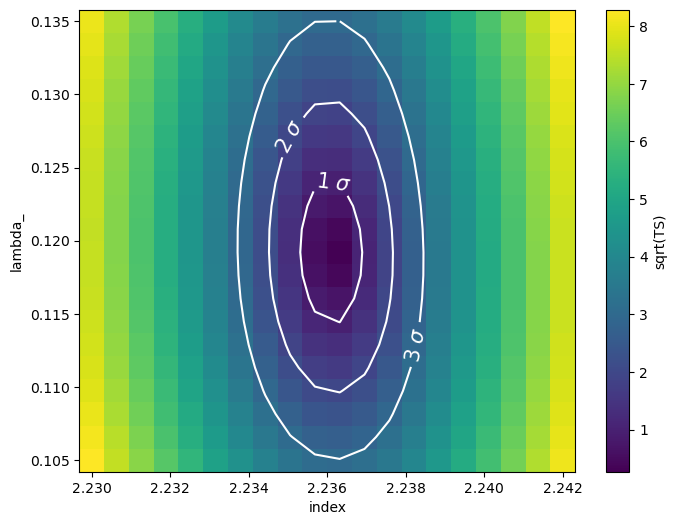

In [93]:
fig, ax = plt.subplots(figsize=(8, 6))
x_values = par_index.scan_values
y_values = par_lambda.scan_values

# plot surface
im = ax.pcolormesh(x_values, y_values, stat_surface, shading="auto")
fig.colorbar(im, label="sqrt(TS)")
ax.set_xlabel(f"{par_index.name}")
ax.set_ylabel(f"{par_lambda.name}")

# We choose to plot 1 and 2 sigma confidence contours
levels = [1, 2, 3]
contours = ax.contour(x_values, y_values, stat_surface, levels=levels, colors="white")
ax.clabel(contours, fmt="%.0f $\\sigma$", inline=3, fontsize=15)

plt.show()

# Exercise:

- Load the Crab Nebula spectral points again and fit them with the Exponential Cut-Off Powerlaw spectral model twice: one Fit with the `ExpCutoffPowerLawSpectralModel` and another Fit with `SuperExpCutoffPowerLaw3FGLSpectralModel`. See [Model gallery](https://docs.gammapy.org/dev/user-guide/model-gallery/index.html).

- Calculate the value of the quantity $-2\mathrm{ln}\,\mathcal{L}$ for the two models and perform the statistical test between the two models above using the Likelihood Ratio test ($TS = -2\Delta\mathrm{ln}(\mathcal{L})$).

- What is the best fit? Which model best describes the data?
